## Define the game environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from game import *
import os
import time
os.environ["CUDA_VISIBLE_DEVICES"]=""
%matplotlib inline

## Testing the environment

In [2]:
#Built in environment check
from stable_baselines3.common.env_checker import check_env
env = Snake_game()
# If the environment doesn't follow the interface, an error will be thrown
check_env(env, warn=True)

c:\Users\cvesw\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:130: UserWarning: Your observation grid has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


## Monitoring
We should set up some monitoring for the training using built-in function of stable-baselines (for more advanced version see TensorBoard) and store the parameters of the best performing model

In [3]:
from stable_baselines3.common.callbacks import BaseCallback
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, '{}_best_model_{}'.format(str(time.time()).split('.')[0], self.n_calls))
            self.model.save(model_path)

        return True

In [4]:
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
import os
#Logging
# Instantiate the env
env = Snake_game()
LOG_DIR = './logs_tensorboard/'
CHECKPOINT_DIR = './train_checkpoints/'
#Callback, this built-in function will periodically evaluate the model and save the best version
# eval_callback = EvalCallback(env, best_model_save_path='./log/',
#                              log_path='./log/', eval_freq=5000,
#                              deterministic=False, render=False)
eval_callback = TrainAndLoggingCallback(check_freq=5000, save_path=CHECKPOINT_DIR)

## Training

In [5]:
import time
from stable_baselines3 import PPO

#Train the agent
max_total_step_num = 10 ** 3

def learning_rate_schedule(progress_remaining):
    start_rate = 0.0005 #0.0003
    #Can do more complicated ones like below
    #stepnum = max_total_step_num*(1-progress_remaining)
    #return 0.003 * np.piecewise(stepnum, [stepnum>=0, stepnum>4e4, stepnum>2e5, stepnum>3e5], [1.0,0.5,0.25,0.125 ])
    return start_rate * progress_remaining #linearly decreasing


starttime = time.time()

model = PPO('MultiInputPolicy', env, learning_rate = learning_rate_schedule, tensorboard_log=LOG_DIR, gamma = 0.99, verbose = 0, ent_coef = 0.0, clip_range = 0.2)
#Load previous best model parameters, we start from that
if os.path.exists("log/best_model.zip"):
    model.set_parameters("log/best_model.zip")
model.learn(max_total_step_num,callback=eval_callback, progress_bar = True)
dt = time.time()-starttime
print("Calculation took %g hr %g min %g s"%(dt//3600, (dt//60)%60, dt%60) )

Output()

Calculation took 0 hr 0 min 24.3915 s


### Check performance
Basic plotting with built-in functions

In [6]:
from stable_baselines3.common import results_plotter
# Helper from the library, a bit hard to read but immediately useable
results_plotter.plot_results(["log"], 1e7, results_plotter.X_TIMESTEPS,'')

LoadMonitorResultsError: No monitor files of the form *monitor.csv found in log

Custom plotting

In [7]:
#A bit more advanced plotting
def adjust_font(lgnd=None, lgnd_handle_size=64, fig=None, ax_fontsize=16, labelfontsize=16,do_ticks=True ):
    if not (lgnd is None):
        for handle in lgnd.legendHandles:
            handle.set_sizes([lgnd_handle_size])
    if not (fig is None):
        ax_list = fig.axes
        for ax1 in ax_list:
            ax1.tick_params(axis='both', labelsize=ax_fontsize)
            ax1.set_xlabel(ax1.get_xlabel(),fontsize=labelfontsize)
            ax1.set_ylabel(ax1.get_ylabel(),fontsize=labelfontsize)
            if do_ticks:
                ax1.minorticks_on()
                ax1.tick_params(axis='both',which='both', direction='in',top=True,right=True)

max_possible_reward =env.REWARD_PER_FOOD * np.sum(env.init_grid==env.EMPTY)

from stable_baselines3.common.monitor import load_results
train_step_log = load_results("log")
x = np.array(train_step_log["l"].cumsum())
y = np.array(train_step_log["r"])

plot_from_step = 0
y = y[x>=plot_from_step]; x = x[x>=plot_from_step]

fig1, ax1 = plt.subplots(1,1)
fig1.set_size_inches(16, 9)

max_points_to_plot = 20000
index_to_plot = np.linspace(0,len(train_step_log)-1,np.clip(len(train_step_log),None,max_points_to_plot)).astype(int)
plt.scatter(x[index_to_plot],y[index_to_plot], alpha=0.3, s=10)

x_edges = np.linspace(x.min(),x.max(),num=30)
xbins = (x_edges[:-1]+x_edges[1:])/2.0
binnumber = np.digitize(x, x_edges) - 1
reward50=np.zeros_like(xbins); reward75=np.zeros_like(xbins); reward25=np.zeros_like(xbins); reward_mean=np.zeros_like(xbins)
reward_max = np.zeros_like(xbins)
for i in range(len(xbins)):
    ind=(binnumber==i)
    if (np.sum(ind)>0):
        reward_mean[i] = np.mean(y[ind])
        reward50[i]=np.median(y[ind])
        reward25[i]=np.percentile(y[ind],25)
        reward75[i]=np.percentile(y[ind],75)
        reward_max[i] = np.max(y[ind])

plt.plot(xbins,reward_max,c='g',lw=2, label="Best")        
plt.plot(xbins,reward_mean,c='r',lw=2, label="Mean")
#plt.plot(xbins,reward50,c='k',lw=2, label="Median")
#plt.plot(xbins,reward75,'--',c='k',lw=2, label="Interquartile range")
#plt.plot(xbins,reward25,'--',c='k',lw=2)
if plt.ylim()[1]>0.8*max_possible_reward:
    plt.axhline(y=max_possible_reward, c='r', linestyle=':')
plt.xlim([0,x.max()])
plt.xlabel('Timesteps'); plt.ylabel('Reward')
plt.legend(fontsize=16)
adjust_font(fig=fig1)
plt.savefig("snake_rewards.png",dpi=150, bbox_inches="tight")
plt.show()

LoadMonitorResultsError: No monitor files of the form *monitor.csv found in log

## Demonstration
Once we have trained a model we can make a movie of it playing the game (which can also be used to see what behaviors it might have problems with that we can correct for in e.g., the reward scheme)

In [ ]:
#Load back the best model
model.set_parameters("log/best_model.zip")
from stable_baselines3.common.evaluation import evaluate_policy
# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print("Best model's reward: %3.3g +/- %3.3g"%(mean_reward,std_reward))

Best model's reward: 51.8 +/- 1.99


Step 1 Action:  2 Tot. Reward: -21
Game over! tot. reward= -21


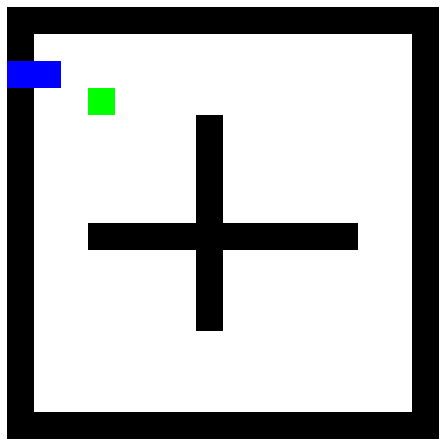

In [8]:
# Test the trained agent and save animation
obs = env.reset()
#Framework to save animgif
fig, ax = plt.subplots(figsize=(6,6))
plt.axis('off')
frames = []
fps=18

n_steps = 1000
tot_reward = 0
for step in range(n_steps):
    action, _ = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    tot_reward += reward
    print("Step {}".format(step + 1),"Action: ", action, 'Tot. Reward: %g'%(tot_reward))
    #print('position=', obs['position'], 'direction=', obs['direction'])
    #env.render(mode='console')
    frames.append([ax.imshow(env.render(mode='rgb_array'), animated=True)])
    if done:
        print("Game over!", "tot. reward=", tot_reward)
        break
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None) #to remove white bounding box 
anim = animation.ArtistAnimation(fig, frames, interval=int(1000/fps), blit=True,repeat_delay=1000)
anim.save("snake_best.gif",dpi=150)